<a href="https://colab.research.google.com/github/Zinga18018/Ipynb_Project_Snippets/blob/main/Simple_deep_Learning_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Project: Image Classification with CNNs on CIFAR-10 using PyTorch

**Goal**: Build a Convolutional Neural Network (CNN) to classify images from the CIFAR-10 dataset.

**CIFAR-10 Dataset**: This dataset consists of 60,000 32x32 color images in 10 classes, with 6,000 images per class. There are 50,000 training images and 10,000 test images.

Here's a breakdown of the steps we'll take:

1.  **Load and Prepare Data**: Download and load the CIFAR-10 dataset, apply necessary transformations.
2.  **Define the CNN Model**: Design a simple CNN architecture using PyTorch's `nn.Module`.
3.  **Define Loss Function and Optimizer**: Choose appropriate loss and optimization techniques.
4.  **Train the Model**: Write a training loop to iterate over the dataset, perform forward and backward passes, and update model weights.
5.  **Evaluate the Model**: Test the trained model on the unseen test set and report accuracy.
6.  **Visualize Results (Optional but Recommended)**: Display some predictions and misclassifications.

Let's start by setting up the environment and loading the data!

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Check for GPU availability
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


### Step 1: Load and Prepare Data

We'll define transformations for the images (e.g., converting them to tensors and normalizing them). Then, we'll download the CIFAR-10 training and test datasets.

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

print("Data loaded successfully!")

100%|██████████| 170M/170M [00:03<00:00, 48.9MB/s]


Data loaded successfully!


Let's visualize a few training images to understand the dataset.

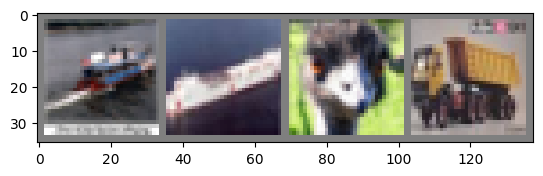

ship  ship  bird  truck


In [3]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# Get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# Show images
imshow(torchvision.utils.make_grid(images))
# Print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

### Step 2: Define the CNN Model

Now we'll define our Convolutional Neural Network. We'll use a simple architecture with a few convolutional layers, pooling layers, and fully connected layers.

In [4]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5) # 3 input channels (RGB), 6 output channels, 5x5 kernel
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120) # 16 filters, 5x5 feature map size after pooling
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10) # 10 output classes

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()
net.to(device)
print("CNN model defined and moved to device!")

CNN model defined and moved to device!


### Step 3: Define Loss Function and Optimizer

For classification, we typically use Cross-Entropy Loss, and for optimization, Stochastic Gradient Descent (SGD) is a common choice.

In [5]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

print("Loss function and optimizer defined!")

Loss function and optimizer defined!


### Step 4: Train the Model

This is the core training loop. We will iterate over the training data multiple times (epochs), feed inputs to the network, get predictions, calculate loss, and update weights.

In [6]:
epochs = 5 # You can increase this for better accuracy

for epoch in range(epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

# Save the trained model
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)
print(f"Model saved to {PATH}")

[1,  2000] loss: 2.233
[1,  4000] loss: 1.880
[1,  6000] loss: 1.691
[1,  8000] loss: 1.579
[1, 10000] loss: 1.548
[1, 12000] loss: 1.477
[2,  2000] loss: 1.404
[2,  4000] loss: 1.397
[2,  6000] loss: 1.375
[2,  8000] loss: 1.346
[2, 10000] loss: 1.285
[2, 12000] loss: 1.305
[3,  2000] loss: 1.218
[3,  4000] loss: 1.215
[3,  6000] loss: 1.225
[3,  8000] loss: 1.201
[3, 10000] loss: 1.187
[3, 12000] loss: 1.194
[4,  2000] loss: 1.140
[4,  4000] loss: 1.109
[4,  6000] loss: 1.092
[4,  8000] loss: 1.123
[4, 10000] loss: 1.103
[4, 12000] loss: 1.102
[5,  2000] loss: 0.999
[5,  4000] loss: 1.055
[5,  6000] loss: 1.030
[5,  8000] loss: 1.042
[5, 10000] loss: 1.049
[5, 12000] loss: 1.047
Finished Training
Model saved to ./cifar_net.pth


### Step 5: Evaluate the Model

After training, we'll load the saved model and evaluate its performance on the test dataset to see how well it generalizes to unseen data.

In [7]:
net = Net()
net.load_state_dict(torch.load(PATH))
net.to(device)

correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

# Evaluate accuracy for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy of the network on the 10000 test images: 59 %
Accuracy for class: plane is 56.5 %
Accuracy for class: car   is 70.5 %
Accuracy for class: bird  is 52.3 %
Accuracy for class: cat   is 54.6 %
Accuracy for class: deer  is 38.0 %
Accuracy for class: dog   is 31.9 %
Accuracy for class: frog  is 82.0 %
Accuracy for class: horse is 55.6 %
Accuracy for class: ship  is 74.2 %
Accuracy for class: truck is 74.5 %


### Step 6: Visualize Results (Optional)

Let's see some predictions!

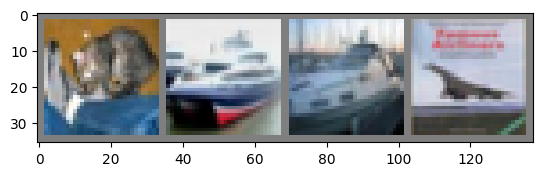

GroundTruth:  cat   ship  ship  plane
Predicted:    cat   car   car   ship 


In [8]:
# Get some random test images
dataiter = iter(testloader)
images, labels = next(dataiter)

# Print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

# Make predictions
outputs = net(images.to(device))
_, predicted = torch.max(outputs, 1)

print('Predicted:   ', ' '.join(f'{classes[predicted[j]]:5s}' for j in range(4)))